## IMPORTANT NOTE

please use [THIS LINK](https://nbviewer.jupyter.org/github/Korf74/ADA/blob/master/03%20-%20Interactive%20Viz/Remi.ipynb) to see the notebook with the maps displayed.

In [9]:
import pandas as pd
import re
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

First We import json and folium, and we make sure we have the right version.

In [10]:
import json
import folium

folium.__version__ == '0.5.0'

True

The first step is to retrieve the data from eurostat. The format is *tsv* and it contains unemployment rates in the EU from 2007 to 2016. We'll only keep the 2016 data.

We delete unwanted rows (whole EU for example), and make the rates to be floats.

In [11]:
df = pd.read_csv('eurostat.tsv', sep='\t')
df.columns = ['Region', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016']
df = df[['Region', '2016']]
df['Region'] = df['Region'].apply(lambda x: x.split(',', 1)[0])
df.drop(df.tail(2).index, inplace=True)
df.drop(df.head(6).index, inplace=True)

df['2016'] = df['2016'].apply(lambda x: re.sub('[bui ]', '', x)).astype('float')
df['Region'] = df['Region'].replace('Germany (until 1990 former territory of the FRG)', 'Germany')
df

,Region,2016
6,Belgium,4.7
7,Bulgaria,4.5
8,Czech Republic,2.6
9,Denmark,4.3
10,Germany,2.9
11,Estonia,4.8
12,Ireland,5.1
13,Greece,14.1
14,Spain,12.8
15,France,6.1


In [12]:
df.describe()

,2016
count,31.000000
mean,5.364516
std,2.652112
min,2.500000
25%,3.650000
50%,4.800000
75%,6.150000
max,14.100000


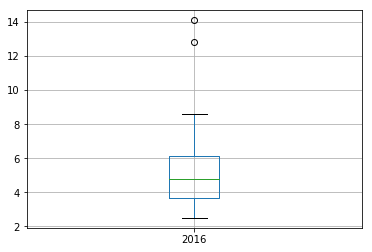

In [13]:
df.boxplot()

As you can see, unemployment rates range from 2.5 to 14.1% with a 5.36 mean and 4.8 median. The EU average is slightly above Switzerland's.

Note that there are two big outliers : Greece at 14.1% and Spain at 12.8%, thus we'll have to be careful about it, and we should now rely on the mean, rather on the median that is more robust to outliers.

We then create our map and get the topojson that was given.

In [14]:
m_eu = folium.Map([54, 15], tiles='cartodbpositron', zoom_start=4)

In [15]:
js = r'topojson/europe.topojson.json'
js_data = json.load(open(js))
js_data['objects']['europe']['geometries'][:3]

[{'arcs': [[[0, 1, 2]], [[3]], [[4]], [[5, 6, 7, 8, 9, 10], [11]]],
  'id': 'AZ',
  'properties': {'NAME': 'Azerbaijan'},
  'type': 'MultiPolygon'},
 {'arcs': [[12, 13, 14, 15, 16, 17, 18]],
  'id': 'AL',
  'properties': {'NAME': 'Albania'},
  'type': 'Polygon'},
 {'arcs': [[[-12]], [[19, -3, 20, 21, -7], [-5], [-4]]],
  'id': 'AM',
  'properties': {'NAME': 'Armenia'},
  'type': 'MultiPolygon'}]

Displayed above is a sample of json informations for each european country.

The next step is to get all country names and keep only those for which we have informations.

In [16]:
regions = df['Region'].tolist()
countries = pd.DataFrame(
    {'Region': 
     [x['properties']['NAME'] for x in js_data['objects']['europe']['geometries'] if x['properties']['NAME'] in regions]}
)
countries

,Region
0,Bulgaria
1,Cyprus
2,Denmark
3,Ireland
4,Estonia
5,Austria
6,Czech Republic
7,Finland
8,France
9,Germany


In [17]:
data_map = countries.merge(df, on='Region', how='outer')
data_map

,Region,2016
0,Bulgaria,4.5
1,Cyprus,8.6
2,Denmark,4.3
3,Ireland,5.1
4,Estonia,4.8
5,Austria,4.1
6,Czech Republic,2.6
7,Finland,5.8
8,France,6.1
9,Germany,2.9


In [18]:
eu = js_data['objects']['europe']['geometries']
regs = data_map['Region'].tolist()
new_eu = [x for x in eu if x['properties']['NAME'] in regs]
js_data['objects']['europe']['geometries'] = new_eu

We can now draw the map. By using a style function and the data manipulation above, we draw in grey countries for which we don't have data.

In [19]:
def color_country(name):
    if(name in regs):
        return '#996DAD'
    else:
        return '#727272'

In [20]:
folium.TopoJson(open(js), 'objects.europe',
               style_function=lambda feature: {
                'fillColor': color_country(feature['properties']['NAME']),
                'color': 'black',
                'weight': 2   
                }).add_to(m_eu)

In [21]:
m_eu

# The Choropleth Map

We can now draw our choropleth map above the topological one, which permits to keep track of countries without data.

Recall that there are two big outliers in the data. What we chose to do is to create 5 different classes, that roughly represent quantiles and outliers so that the choropleth map will show countries with similar unemployment rates in the same color.

We first draw the basic map for comparison.

In [22]:
m_eu.choropleth(geo_data=js_data, data=data_map,
         columns=['Region', '2016'],topojson = 'objects.europe',
         key_on='feature.properties.NAME',
         fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
         legend_name='unemployment rates for countries within Europe', highlight = True)

In [23]:
%%HTML
<iframe width=100% height=850 src="ex1_choropleth1.html"></iframe>

In [24]:
df.describe()

,2016
count,31.000000
mean,5.364516
std,2.652112
min,2.500000
25%,3.650000
50%,4.800000
75%,6.150000
max,14.100000


In [25]:
def assign_class(n):
    if n < 3.65:
        return 0
    elif n < 4.8:
        return 1
    elif n < 6.15:
        return 2
    elif n < 10:
        return 3
    else:
        return 4

In [26]:
data_map['2016'] = data_map['2016'].apply(assign_class)

In [27]:
m_eu.choropleth(geo_data=js_data, data=data_map,
         columns=['Region', '2016'],topojson = 'objects.europe',
         key_on='feature.properties.NAME',
         fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
         legend_name='similar unemployment rates for countries within Europe', highlight = True)

In [28]:
%%HTML
<iframe width=100% height=850 src="ex1_choropleth2.html"></iframe>